# Supplement A
# Microwave Radiometer Temperature and Humidity Retrieval

In the following, we introduce the use of the pyOptimalEstimation Python library using a standard temperature and humidity retrieval using a microwave radiometer (MWR, Rose et al 2005). We use the simple forward operator introduced by Löhnert et al. (2004) which does not account for scattering by hydrometeors. The prior is estimated based on almost 16 years of spring (March - May) radiosonde observations at the U.S. Department of Energy Atmospheric Radiation Measurement (ARM) program at the North Slope of Alaska (NSA) site in Utqiagvik (Barrow), Alaska. See the `prepare_radiosondes.ipynb` script in `lib` for details.


# Preparation 
In order to design a retrieval with pyOptimalEstimation, we need to install the library first with 
~~~~  
pip install pyOptimalEstimation
~~~~ 
for Python 2.7 or Python 3. This example uses Python 3.6. It requires the numpy, scipy, pandas and matplotlib libraries to be installed, this example makes use also of the xarray, seaborn, uncertainties, and xarray libraries. For development, we used Numpy 1.16.2, Matpolotlib 3.0.3, Scipy 1.2.1, Xarray 0.11.3, Pandas 0.24.1, Seaborn 0.9.0 and Uncertainties 3.0.3. 

Before we start, we need to load all required Python libraries

In [1]:
import sys
import traceback
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pn
import xarray as xr

import pyOptimalEstimation as pyOE

We put some helper routines and the radiative transfer model in the `lib` folder which we load with 

In [2]:
sys.path.append('lib')
import nonScatMWRadTran
import supporting_routines

# Load data
The mean $\mathbf{x}_{a}$ and covariance **S**$_a$ of the prior have been estimated from the NSA radiosonde data set and are loaded from a NetCDF file. Additionally, the forward operator requires also the height profile and the associated pressure levels. The unit of temperature is Kelvin and specific humidity is provided in $\log_{10}$(g/kg).

In [3]:
allData = xr.open_dataset('data/radiosonde_prior.nc')
allData


<xarray.Dataset>
Dimensions:   (height: 60, season: 5, state: 120, state_T: 120, time: 5)
Coordinates:
  * state     (state) object '00008_q' '00008_t' ... '22508_q' '22508_t'
  * time      (time) datetime64[ns] 2004-03-16T12:00:00 ... 2018-01-08T12:00:00
  * season    (season) object 'all' 'DJF' 'MAM' 'JJA' 'SON'
  * state_T   (state_T) object '00008_q' '00008_t' ... '22508_q' '22508_t'
  * height    (height) float32 8.0 107.99999 207.99997 ... 20008.008 22508.008
Data variables:
    x_truth   (time, state) float32 ...
    x_mean    (season, state) float32 ...
    x_cov     (season, state, state_T) float64 ...
    pressure  (season, height) float32 ...

We use the xarray library which provides a transparent interface to netCDF files so that we can directly copy the required variables form the netCDF file:

In [4]:
x_mean = allData['x_mean']
x_cov = allData['x_cov']
pressure = allData['pressure']
height = allData['height']

The file also contained some atmospheric profiles that were not used to estimate the prior. We will use them to estimate synthetic observations. By this, we can evaluate the retrieval result by comparison with the true atmospheric state and we are not impacted by potential forward operator biases. For this example we use the atmospheric profile at Barrow at 2006-04-01T00:00:00 whihc we call $\mathbf{x}_{truth}$ in the following

In [5]:
profile = np.datetime64('2006-04-01T00:00:00')
season = 'MAM'  #Spring: March April May
x_truth = allData['x_truth'].sel(time=profile)
x_truth

<xarray.DataArray 'x_truth' (state: 120)>
array([-4.480766e-01,  2.480005e+02, -4.756323e-01,  2.472384e+02,
       -3.865508e-01,  2.489023e+02, -3.525377e-01,  2.512350e+02,
       -3.742968e-01,  2.521518e+02, -3.689384e-01,  2.528155e+02,
       -3.805267e-01,  2.532069e+02, -3.856108e-01,  2.534520e+02,
       -3.790951e-01,  2.537908e+02, -3.417674e-01,  2.545065e+02,
       -3.036444e-01,  2.549711e+02, -3.136013e-01,  2.555717e+02,
       -2.889841e-01,  2.558500e+02, -2.685365e-01,  2.560773e+02,
       -2.492627e-01,  2.564157e+02, -2.394222e-01,  2.564438e+02,
       -2.328864e-01,  2.567464e+02, -2.128743e-01,  2.568562e+02,
       -2.328503e-01,  2.567904e+02, -2.652528e-01,  2.566161e+02,
       -2.910133e-01,  2.567371e+02, -2.213393e-01,  2.565475e+02,
       -1.078892e-01,  2.564404e+02,  1.598093e-02,  2.565077e+02,
        4.493195e-02,  2.562920e+02,  3.907263e-02,  2.560003e+02,
        5.369382e-02,  2.559506e+02,  5.750730e-02,  2.557328e+02,
        5.969608e-02

We use the standard frequencies in GHz of an HATPRO microwave radiometer (Rose et al 2005)

In [6]:
frequencies = [
    22.24, 23.04, 23.84, 25.44, 26.24, 27.84, 31.4, 51.26, 52.28, 53.86, 54.94,
    56.66, 57.3, 58.
]

# Define forward operator

Next, we define the forward operator. pyOptimalEstimation requires that the state vector $\mathbf{x}$ is the first argument of the forward operator function and the measurement vector $\mathbf{y}$ is returned. All the magic is handled by the nonScatMWRadTran library (Löhnert et al. 2004), the function `forwardRT` is for converting it to the correct SI units. 

In [7]:
def forwardRT(X, pressure=None, zenithAngle=0, frequencies=[]):

    # X contains T and Q, lets split the vector
    temperature, humidity = supporting_routines.splitTQ(X)
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # Height in meters comes from index of the temperature (or humidty) vector
    heights = temperature.index
    assert np.all(np.diff(heights) > 0)

    # get absolute humidty from specific humdity
    abs_humidity = supporting_routines.q2a(humidity, pressure, temperature)
    
    # run the forward operator
    TB, tau, tau_wv, tau_o2 = nonScatMWRadTran.STP_IM10(
        heights,  # [m]  
        temperature,  # [K]
        pressure,  # [Pa]
        abs_humidity,  # [kgm^-3]
        zenithAngle,  # zenith angle of observation in deg.
        frequencies,  # frequency vector in GHz
    )
    return TB

See the file `lib/nonScatMWRadTran.py` for the actual forward operator code which is in detail described in Löhnert et al. (2004).

# Run reference retrieval
We start with the retrieval configuration we will call the *reference run* in the following

## Prepare retrieval
First, we need names for our $\mathbf{y}$ and $\mathbf{x}$ variables to avoid any confusion. For $\mathbf{y}$, we select the frequencies, for $\mathbf{x}$ we use a string containing the height in meters and the variable name (t or q). 

In [8]:
y_vars = np.array(frequencies)
x_vars = x_mean.state.values
print('y_vars:\n', y_vars)
print('x_vars:\n', x_vars)

y_vars:
 [22.24 23.04 23.84 25.44 26.24 27.84 31.4  51.26 52.28 53.86 54.94 56.66
 57.3  58.  ]
x_vars:
 ['00008_q' '00008_t' '00107_q' '00107_t' '00207_q' '00207_t' '00308_q'
 '00308_t' '00408_q' '00408_t' '00508_q' '00508_t' '00608_q' '00608_t'
 '00707_q' '00707_t' '00807_q' '00807_t' '00907_q' '00907_t' '01007_q'
 '01007_t' '01107_q' '01107_t' '01207_q' '01207_t' '01307_q' '01307_t'
 '01407_q' '01407_t' '01507_q' '01507_t' '01607_q' '01607_t' '01707_q'
 '01707_t' '01807_q' '01807_t' '01907_q' '01907_t' '02007_q' '02007_t'
 '02107_q' '02107_t' '02207_q' '02207_t' '02307_q' '02307_t' '02407_q'
 '02407_t' '02507_q' '02507_t' '02607_q' '02607_t' '02707_q' '02707_t'
 '02807_q' '02807_t' '02907_q' '02907_t' '03007_q' '03007_t' '03107_q'
 '03107_t' '03207_q' '03207_t' '03307_q' '03307_t' '03407_q' '03407_t'
 '03507_q' '03507_t' '03757_q' '03757_t' '04007_q' '04007_t' '04257_q'
 '04257_t' '04507_q' '04507_t' '04758_q' '04758_t' '05008_q' '05008_t'
 '05508_q' '05508_t' '06008_q' '06008_t' '0

The measurement uncertainty is expressed as a covariance matrix (**S**$_y$) which defined following ???. For now, we assume that covariances between the channels can be neglected, i.e. **S**$_y$ is a diagonal matrix. Describing measurement uncertainties (and the prior) with a covariance matrix implies that the variability can be described with a normal distribution.



In [9]:
y_noise = pn.Series(
    [
        0.12026637, 0.10864162, 0.10412012, 0.0918477, 0.10174478, 0.10085633,
        0.10500476, 0.42303663, 0.45658514, 0.26291823, 0.25538793, 0.1773584,
        0.17556195, 0.59489495
    ],
    index=y_vars
)

S_y = pn.DataFrame(
    np.diag(y_noise.values**2),
    index=y_vars,
    columns=y_vars,
)


Note that we used pandas (`pn`) `Series` and `DataFrame` objects which are basically annotated arrays. This makes keeping track of the various elements of $\mathbf{x}$ and $\mathbf{y}$ easier.

**S**$_y$ is visualized with:

Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$')

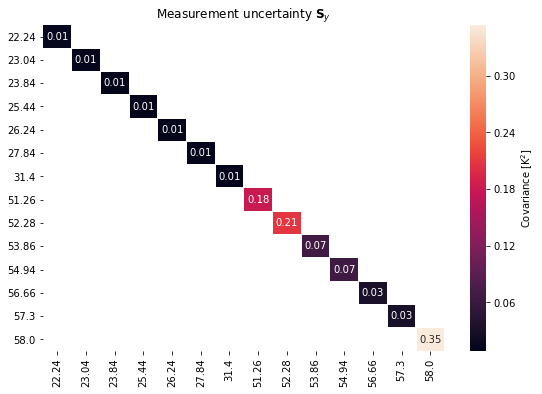

In [10]:

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_y.where(S_y > 0), 
    annot=True, 
    fmt='.2f', 
    ax=ax, 
    linewidths=.05, 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$')


The prior **S**$_a$ is obtained from the mean and covariance matrix provided in the netCDF file loaded above. 

In [11]:
x_a = x_mean.sel(season=season).to_pandas()[x_vars]
S_a = x_cov.sel(season=season).to_pandas().loc[x_vars, x_vars]

We plot them separately for T and q. Note how the Tropopause can be clearly seen around 10 km. We show **S**$_a$ separately for T and q even though we consider correlations between T and q. 

Text(0.5, 1.0, '$\\mathbb{S}_{a}$ Humidity')

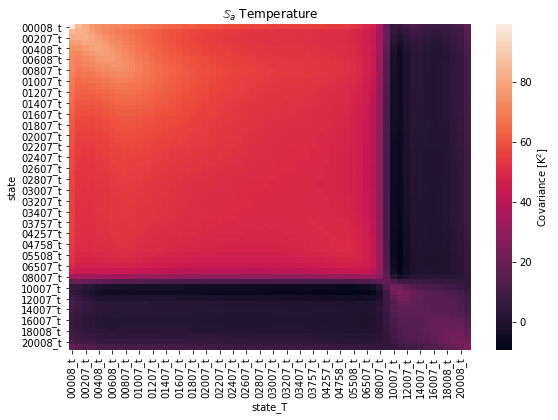

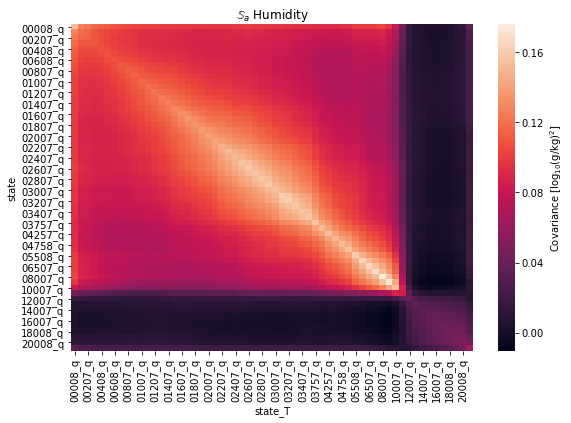

In [12]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Temperature')
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_a.iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{a}$ Humidity')

It is crucial that **S**$_a$ and **S**$_y$ can be inverted. When using different units in $\mathbf{x}$ and/or $\mathbf{y}$ an dmixing very small and large values, the inversion might fail for numerical reasons. In this case we recommend to experiment with different units. 

Note: Numpy's `np.linalg.inv` does not always catch singular matrices:

In [13]:
singularMatrix = np.array([[1,0,0], [1,0,1e-50], [1,1e-50,0]])
np.linalg.inv(singularMatrix)

array([[ 1.e+00,  0.e+00,  0.e+00],
       [-1.e+50,  0.e+00,  1.e+50],
       [-1.e+50,  1.e+50,  0.e+00]])

Therefore, it is recommended to use pyOptimalEstimation's `pyOE.invertMatrix` function which checks for matrix singularity. The `try` and `except` is only to make sure the Notebook does not stop after the error is raised

In [14]:
try:
    pyOE.invertMatrix(singularMatrix)
except Exception as err:
    traceback.print_tb(err.__traceback__)

  File "<ipython-input-14-8c0b799fbd53>", line 2, in <module>
    pyOE.invertMatrix(singularMatrix)
  File "/Users/mmaahn/projects/devel_libs/pyOptimalEstimation/pyOptimalEstimation/pyOEcore.py", line 1206, in invertMatrix
    raise ValueError("Found singular matrix", UserWarning)


Based on the true profile, we create a synthetic observation. Auxiliary data which needs to be passed on to the `forwardRT` function is stored in the `forwardKwArgs` dictionary. The `**forwardKwArgs` passes all dictionary values of `forwardKwArgs` as named function arguments (see https://www.geeksforgeeks.org/args-kwargs-python/).

In [15]:
forwardKwArgs = dict(
    pressure=pressure.sel(season=season),
    zenithAngle=0,
    frequencies=frequencies
)

y_obs = forwardRT(x_truth.to_pandas(), **forwardKwArgs)
y_obs = pn.Series(y_obs, index=y_vars)
assert np.all(np.isfinite(y_obs))

The resulting brightness temperatures are storted in  $\mathbf{y}_{obs}$ (`y_obs`)

In [16]:
y_obs

22.24     14.465517
23.04     13.995871
23.84     12.693847
25.44     11.038715
26.24     10.732210
27.84     10.687470
31.40     11.939956
51.26    105.124614
52.28    143.715403
53.86    230.364095
54.94    251.509452
56.66    250.602579
57.30    250.071957
58.00    249.692744
dtype: float64

`pyOptimalEstimation` uses objects. Therefore, we combine all information for the reference run into an object which we name `oe_ref` 

In [17]:
oe_ref = pyOE.optimalEstimation(
    x_vars, # state variable names
    x_a,  # a priori
    S_a, # a priori uncertainty
    y_vars,  # measurement variable names
    y_obs, # observations
    S_y, # observation uncertainty
    forwardRT, # forward Operator
    forwardKwArgs=forwardKwArgs, # additonal function arguments
    x_truth=x_truth.to_pandas(), # true profile
)

Note that $\mathbf{x}_{truth}$ is only added to the `pyOE` object for convenience, it is not used to find a solution.

## Run retrieval
We are finally ready to run the retrieval. 

In [18]:
oe_ref.doRetrieval()

5.11 s, iteration 1, degrees of freedom: 4.71 of 120. convergence criteria NOT fullfilled  1014.185
7.17 s, iteration 2, degrees of freedom: 4.67 of 120. convergence criteria NOT fullfilled  25.998
9.08 s, iteration 3, degrees of freedom: 4.67 of 120. convergence criteria fullfilled  0.133
10.81 s, iteration 4, degrees of freedom: 4.67 of 120.  Done.  0.000


True

As can be seen from the output, convergence is reached at the third iteration. After convergence, the solution $\mathbf{x}_{op}$ and the retrieved uncertainty **S**$_{op}$ is available with (only the first 10 elements are shown)

In [74]:
print(oe_ref.x_op[:10])
print(oe_ref.S_op[:10])

00008_q     -0.406135
00008_t    249.002329
00107_q     -0.380221
00107_t    248.452024
00207_q     -0.363872
00207_t    248.294208
00308_q     -0.348827
00308_t    249.238030
00408_q     -0.337260
00408_t    250.490945
dtype: float64
          00008_q   00008_t   00107_q   00107_t   00207_q   00207_t   00308_q  \
00008_q  0.016005  0.383114  0.002384 -0.002589  0.001620 -0.099544  0.001929   
00008_t  0.383114  9.767389  0.042065 -0.101623  0.026183 -2.497551  0.035620   
00107_q  0.002384  0.042065  0.004934  0.049977  0.004288  0.000341  0.003564   
00107_t -0.002589 -0.101623  0.049977  1.513066  0.026922  0.409323  0.011944   
00207_q  0.001620  0.026183  0.004288  0.026922  0.006380  0.009663  0.005777   
00207_t -0.099544 -2.497551  0.000341  0.409323  0.009663  1.588158 -0.008598   
00308_q  0.001929  0.035620  0.003564  0.011944  0.005777 -0.008598  0.009360   
00308_t -0.134692 -3.390991 -0.041911 -0.719528 -0.019597  0.972564 -0.009912   
00408_q  0.001961  0.038129  0.00304

pyOptimalEstimation uses Pandas objects not only for the input, but also for the output to make sure the elements of $\mathbf{x}$ and $\mathbf{y}$ are nit mixed up.

For convenience, the one sigma uncertainties derived from **S**$_{op}$ are also available

In [76]:
print(oe_ref.x_op_err[:10])

00008_q    0.126511
00008_t    3.125282
00107_q    0.070245
00107_t    1.230067
00207_q    0.079873
00207_t    1.260222
00308_q    0.096746
00308_t    1.577811
00408_q    0.108868
00408_t    1.775551
dtype: float64




An important output is the degrees of freedom for signal $d$ which describe the number of independent information pieces obtained from the measurement by the retrieval. The final $d$ can be  accessed as a total value, and per element of $\mathrm{x}

In [78]:
print('total', oe_ref.dgf)
print(oe_ref.dgf_x[:10])

total 4.666764016304002
00008_q    0.001979
00008_t    0.244480
00107_q    0.007124
00107_t    0.333153
00207_q    0.009476
00207_t    0.219920
00308_q    0.013627
00308_t    0.150580
00408_q    0.017845
00408_t    0.118008
dtype: float64


## Analyze the results
After running the retrieval, the `oe_ref` object contains also the retrieval result. In addition, `pyOptimalEstimation` provides a tool set of functions to asses model quality as introduced below. We encourage the reader to look at the documentation with `help(oe_ref)` or `oe_ref?` even though we will present the most important features in the following.

In [20]:
help(oe_ref)

Help on optimalEstimation in module pyOptimalEstimation.pyOEcore object:

class optimalEstimation(builtins.object)
 |  The core optimalEstimation class, which contains all required parameters.
 |  
 |  Parameters
 |  ----------
 |  x_vars : list of str
 |      names of the elements of state vector x.
 |  x_a : pd.Series or list or np.ndarray
 |      prior information of state x.
 |  S_a : pd.DataFrame or list or np.ndarray
 |      covariance matrix of state x.
 |  y_vars : list of str
 |      names of the elements of state vector x
 |  y_obs : pd.Series or list or np.ndarray
 |      observed measurement vector y.
 |  S_y : pd.DataFrame or list or np.ndarray
 |      covariance matrix of measurement y. If there is no b vector, S_y
 |      is sequal to S_e
 |  forward : function
 |      forward model expected as ``forward(xb,**forwardKwArgs): return y``
 |      with xb = pd.concat((x,b)).
 |  x_truth : pd.Series or list or np.ndarray, optional
 |      If truth of state x is known, it can 

### Iterations
The function `plotIterations` visualizes the itrations of `pyOptimalEstimation` to the estimated result on the x axis: Iteration 0 is the first guess (in our case the prior), the solid line at iteration 3 is where the retrieval converges. $\mathbf{x}_{truth}$ (first panel) and $\mathbf{y}_{ob}$ (second panel) are on the very right. The degrees of freedom and the convergence criterion (see Sec. 5.6.2 of Rodgers, 2000) are displayed in the third and fourth panel, respectively.

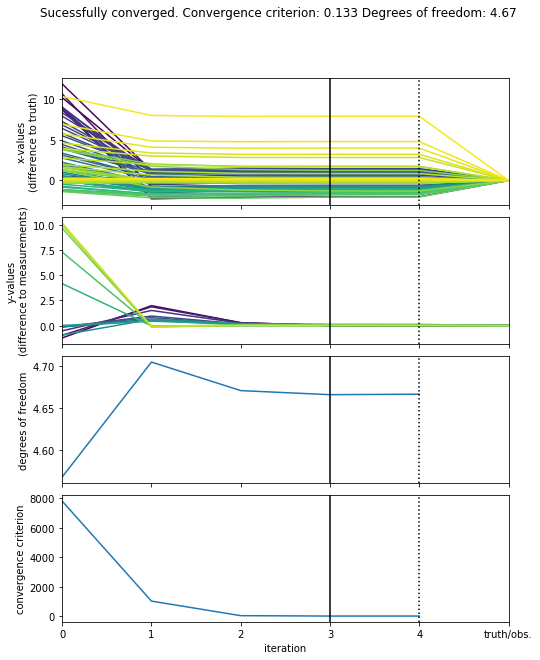

In [21]:
fig = oe_ref.plotIterations(legend=False, mode='difference')

### Solution
The optimal solution $\mathbf{x}_{optimal}$ can be accessed with 

In [22]:
oe_ref.x_op

00008_q     -0.406135
00008_t    249.002329
00107_q     -0.380221
00107_t    248.452024
00207_q     -0.363872
00207_t    248.294208
00308_q     -0.348827
00308_t    249.238030
00408_q     -0.337260
00408_t    250.490945
00508_q     -0.320610
00508_t    251.672697
00608_q     -0.289281
00608_t    252.990886
00707_q     -0.266166
00707_t    254.110426
00807_q     -0.262945
00807_t    254.991008
00907_q     -0.246178
00907_t    255.754758
01007_q     -0.232916
01007_t    256.421922
01107_q     -0.229891
01107_t    256.839280
01207_q     -0.228790
01207_t    257.171413
01307_q     -0.228472
01307_t    257.436398
01407_q     -0.210215
01407_t    257.641902
              ...    
07007_q     -0.888300
07007_t    229.189343
08007_q     -1.253285
08007_t    222.756796
09007_q     -1.605786
09007_t    218.507654
10007_q     -1.994312
10007_t    217.923971
11007_q     -2.270618
11007_t    219.476207
12007_q     -2.406767
12007_t    221.412751
13007_q     -2.412446
13007_t    222.206029
14007_q   

and the according posterior correlation $\mathbb{S}_{optimal}$ is accesible as `oe_ref.S_op ` which we plot with

Text(0.5, 1.0, '$\\mathbb{S}_{op}$ Humidity')

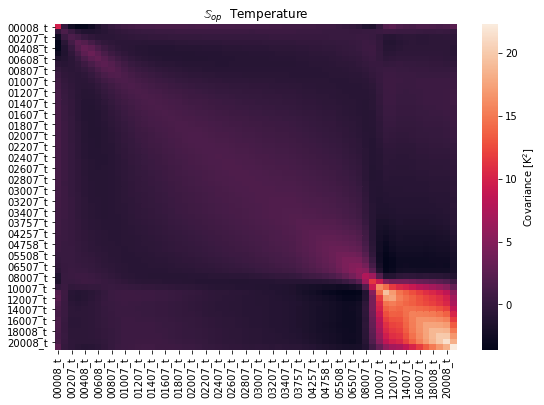

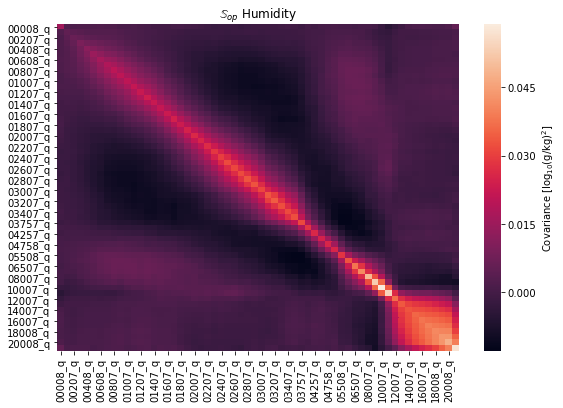

In [23]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[1::2, 1::2], ax=ax, cbar_kws={'label':'Covariance [K$^2$]'})
ax.set_title('$\mathbb{S}_{op}$  Temperature')

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(oe_ref.S_op .iloc[::2, ::2], ax=ax, cbar_kws={'label':'Covariance [log$_{10}$(g/kg)$^2$]'})
ax.set_title('$\mathbb{S}_{op}$ Humidity')

The square of the diagonal of are the uncertainties of the optimal solution (1 sigma range) which can be also found in 

In [24]:
oe_ref.x_op_err

00008_q    0.126511
00008_t    3.125282
00107_q    0.070245
00107_t    1.230067
00207_q    0.079873
00207_t    1.260222
00308_q    0.096746
00308_t    1.577811
00408_q    0.108868
00408_t    1.775551
00508_q    0.121020
00508_t    1.856372
00608_q    0.129784
00608_t    1.737184
00707_q    0.135304
00707_t    1.590892
00807_q    0.142298
00807_t    1.506774
00907_q    0.143158
00907_t    1.365099
01007_q    0.143345
01007_t    1.278578
01107_q    0.147477
01107_t    1.245865
01207_q    0.149138
01207_t    1.207402
01307_q    0.154277
01307_t    1.210161
01407_q    0.150133
01407_t    1.204583
             ...   
07007_q    0.203030
07007_t    2.375334
08007_q    0.221955
08007_t    2.771506
09007_q    0.230324
09007_t    3.382150
10007_q    0.242348
10007_t    4.014123
11007_q    0.233183
11007_t    4.411158
12007_q    0.191671
12007_t    4.201254
13007_q    0.183755
13007_t    3.811021
14007_q    0.182271
14007_t    3.815260
15007_q    0.189136
15007_t    3.935313
16007_q    0.194446


Using a specific helper routine from `lib/supporting_routines.py` , we plot the prior and the result as vertical profiles of temperature and humidity.

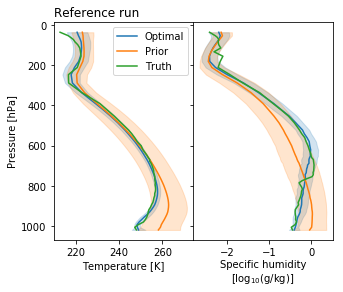

In [25]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='Reference run')

### Root mean square error
`supporting_routines` also contains a helper routine to split $\mathbf{x}$ into temperature and humidity. This allows us to e.g. estimate the root mean square errors (RMS) for $\mathbf{x}$ (and $\mathbf{y}$)

In [26]:
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_truth)

print('RMS X Temperature: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('RMS X Humidity: %g [log$_{10}$(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))
print('RMS Y %g [K]'% np.sqrt(np.mean((oe_ref.y_obs - oe_ref.y_op)**2)))

RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]


Note that we can only estimate the RMS for $\mathbf{x}$, because we used synthetic observations and know $\mathbf{x}_{truth}$

### Statistical tests

We recommend to apply various statistical tests to the result with the `chiSquareTest()` function. The tests include:

1. $\mathbf{y}_{op}$  agrees with the measurement $\mathbf{y}_{obs}$ (`Y_Optimal_vs_Observation`, Rodgers, 2000, Sec. 12.3.2) 
2. the observation $\mathbf{y}_{obs}$ agrees with the prior $\mathbb{S}_a$ (`Y_Observation_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.1) 
3. the retrieved measurement agrees with the prior $\mathbb{S}_a$ (`Y_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.3) 
4. the retrieved state $\mathbf{x}_{op}$ agrees with the prior $\mathbb{S}_a$ (`X_Optimal_vs_Prior`, Rodgers, 2000, Sec. 12.3.3.2) 


In [27]:
chiSquareTest = oe_ref.chiSquareTest(significance=0.05)

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       


The first returned element is a boolean indicating whether the $\chi^2$ tests were successful: 

In [28]:
print('\nTests passed:\n' ,chiSquareTest[0])


Tests passed:
 chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool


### Linearity tests
Finally, we test with `testLinearity()`  whether the forward operator is moderately linear following chapter 5.1 of Rodgers 2000. The analysis for this example is based on $\mathbf{x}_{truth}$. The $\chi^2$ value (`trueLinearityChi2`) corresponding to the model beeing moderately linear must be smaller than the critical value (`trueLinearityChi2Crit`).

In [29]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_ref.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  True


In case $\mathbf{x}_{truth}$ is  unknown, error patterns of $\mathbb{S}$ can be used instead (`linearity`). Values lower than 1 indicate that the effect of linearization is smaller than the measurement error and problem is nearly linear. Note that this is less accurate than when $\mathbf{x}_{truth}$ is known.

# Run modified retrieval
In the following, we modify the retrieval in various ways and asses the impact on retrieval quality. The reader is strongly encouraged to play around with the various parameters. 

## Modify prior: Ignoring non-diagonal elements of   **S**$_a$

The prior data set is crucial for selecting the most likely atmospheric state for a given measurement. Here, we investigate what happens when only diagonal values in **S**$_a$ are considered, i.e. correlations are ignored. 

In [30]:
x_a = x_mean.sel(season='MAM').to_pandas()  # as before
S_a = x_cov.sel(season='MAM')  # as before
S_a_diag = np.diag(np.diag(S_a))

The retrieval needs six iterations to converge which also indicates the larger instability of the retrieval

In [31]:
oe_diag = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a_diag,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_diag.doRetrieval()

4.17 s, iteration 1, degrees of freedom: 4.50 of 120. convergence criteria NOT fullfilled  179.076
6.06 s, iteration 2, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  11.376
8.02 s, iteration 3, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  2.229
9.76 s, iteration 4, degrees of freedom: 4.54 of 120. convergence criteria NOT fullfilled  3.202
11.71 s, iteration 5, degrees of freedom: 4.53 of 120. convergence criteria NOT fullfilled  1.487
13.90 s, iteration 6, degrees of freedom: 4.53 of 120. convergence criteria fullfilled  0.079
15.91 s, iteration 7, degrees of freedom: 4.53 of 120.  Done.  0.002


True

The degrees of freedom are reduced with respect to the reference run

In [32]:
oe_diag.dgf, oe_ref.dgf

(4.530899292684366, 4.666764016304002)


Most importantly, a comparison of the retrieved vertical profiles shows that 

1. the solution remains closer to the prior.
2. the uncertainties of the solution are greatly enhanced
3. the solution has non-physical artifacts

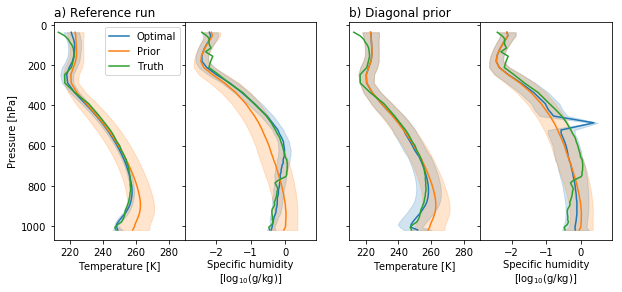

In [33]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_diag,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Diagonal prior',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)



The decreased quality of the solution can be also seen from the increased RMS errors:

In [34]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Diagonal prior:')
supporting_routines.print_mwr_rms(oe_diag)


Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Diagonal prior:
RMS X Temperature: 2.42742 [K]
RMS X Humidity: 0.428865 [log$_{10}$(g/kg)]
RMS Y 0.0724113 [K]



Also, all but one statistical $\chi^2$ tests fail in this case. 

In [35]:
print(oe_diag.chiSquareTest()[0])

Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior       True
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


And the forward operator doe snot behave moderately linear

In [36]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_diag.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


In summary, the non-diagonal elements of  **S**$_a$ are crucial for such a retrieval configuration with much larger state than measurement space.

## Modify prior: Using summer instead of spring data 


Here we investigate what happens with the retrieval if an unsuited prior is selected. For this we swap the prior $\mathbf{x}_a$ and **S**$_a$ with data based on summer instead of spring observations


In [37]:
x_a = x_mean.sel(season='JJA').to_pandas()
S_a = x_cov.sel(season='JJA').to_pandas()


In [38]:

oe_sum = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_y,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_sum.doRetrieval()

4.14 s, iteration 1, degrees of freedom: 4.62 of 120. convergence criteria NOT fullfilled  7269.663
6.36 s, iteration 2, degrees of freedom: 4.52 of 120. convergence criteria NOT fullfilled  411.238
8.67 s, iteration 3, degrees of freedom: 4.50 of 120. convergence criteria NOT fullfilled  9.942
10.48 s, iteration 4, degrees of freedom: 4.50 of 120. convergence criteria fullfilled  0.059
12.20 s, iteration 5, degrees of freedom: 4.50 of 120.  Done.  0.000


True

The retrieval needs 4 instead of 3 iterations to converge, the retrieved $d$ is reduced 

In [39]:
oe_ref.dgf, oe_sum.dgf

(4.666764016304002, 4.499138003991362)


The vertical profiles show that the true profile is clearly outside of the 1 sigma range of the prior. This is particularly related to biases in the upper atmosphere (200 – 300 hPa) and close to the surface where $\mathbf{x}_{op}$ bends away from $\mathbf{x}_{truth}$ towards $\mathbf{x}_a$. 



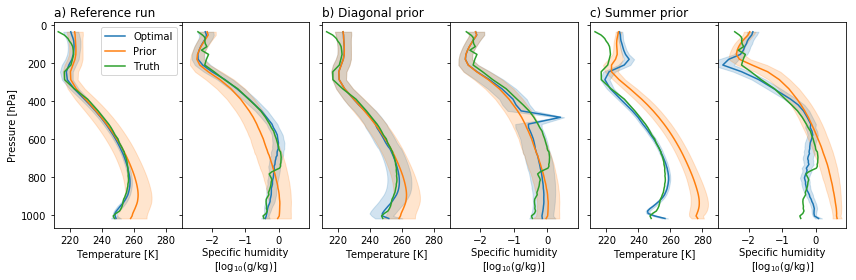

In [68]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_diag,
    oe3 = oe_sum,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Diagonal prior',
    title3='c) Summer prior',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)
fig.tight_layout()
fig.savefig('figure2.pdf')


In comparison to the reference run, the RMS is greatly enhanced

In [41]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Summer prior:')
supporting_routines.print_mwr_rms(oe_sum)

Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Summer prior:
RMS X Temperature: 5.04366 [K]
RMS X Humidity: 0.309074 [log$_{10}$(g/kg)]
RMS Y 0.145272 [K]


Most importantly, all $\chi^2$ tests clearly fail. This is crucial because in a real-world application $\mathbf{x}_{truth}$ is typically unknown and the RMS cannot be estimated. The $\chi^2$ tests can give  the user a warning about potential retrieval issues.


In [42]:
print(oe_sum.chiSquareTest()[0])

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    False
Y_Observation_vs_Prior      False
Y_Optimal_vs_Prior          False
X_Optimal_vs_Prior          False
dtype: bool


This is also true for the linearity test which also fails

In [43]:
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_sum.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Linearity test passed:  False


## Consider forward operator uncertainty

So far, we used the widespread assumption that the microwave forward operator does not have any errors. Of course, this is usually not the case as shown by Cimini et al. (2018) who analyzed the forward model error associated with common forward operator assumptions extensively. We do not intent to reproduce their results here, but instead use their error estimate in y-space (their Fig 9) **S**$_b$ and add it to our assumed measurement uncertainty (i.e. **S**$_e$ = **S**$_y$ + **S**$_b$). Cimini et al. (2018) found the largest uncertainties related to representation of oxygen line in the V-band:

In [44]:
S_b = pn.DataFrame(
    np.array([
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3, 0.3, 0.1, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 3.0, 3.3, 1.2, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.3, 0.4, 0.4, 0.4, 0.5, 0.7, 8.7, 9.2, 0.3, 0.3, 0.0, 0.0, 0.0],
        [0.3, 0.4, 0.4, 0.4, 0.5, 0.5, 0.7, 8.2, 8.7, 0.3, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.7, 0.7, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.5, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.4, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.4, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
        [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3, 0.3, 0.0, 0.0, 0.0, 0.0, 0.0],
    ]),
    index=frequencies[::-1],
    columns=frequencies)

Text(0.5, 1.0, 'Model uncertainty $\\mathbf{S}_{b}$ (Cimini et al. 2018)')

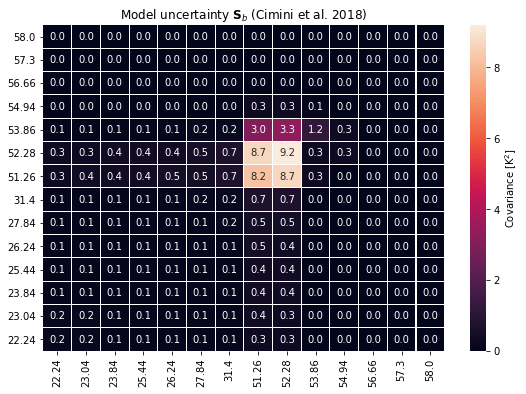

In [45]:
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(
    S_b, 
    annot=True, 
    linewidths=.05, 
    ax=ax, 
    fmt='.1f', 
    cbar_kws={'label':'Covariance [K$^2$]'}
)
ax.set_title(r'Model uncertainty $\mathbf{S}_{b}$ (Cimini et al. 2018)')

To run the retrieval, we combine $\mathbb{S}_{yb}$ and $\mathbb{S}_{y}$. The retrieval converges after only two iterations

In [46]:
x_a = x_mean.sel(season='MAM').to_pandas() # as for the reference run
S_a = x_cov.sel(season='MAM').to_pandas() # as for the reference run
S_e = S_y + S_b

oe_b = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_e,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_b.doRetrieval()


5.66 s, iteration 1, degrees of freedom: 3.81 of 120. convergence criteria NOT fullfilled  10.278
7.86 s, iteration 2, degrees of freedom: 3.77 of 120. convergence criteria fullfilled  0.174
9.85 s, iteration 3, degrees of freedom: 3.77 of 120.  Done.  0.002


True

However, the retrieved *d* are reduced by 0.9 which shows the substantial role **S**$_b$ can play for retrieval quality. 

In [47]:
oe_ref.dgf, oe_b.dgf

(4.666764016304002, 3.770483398353348)

At first sight, the vertical profiles look similar


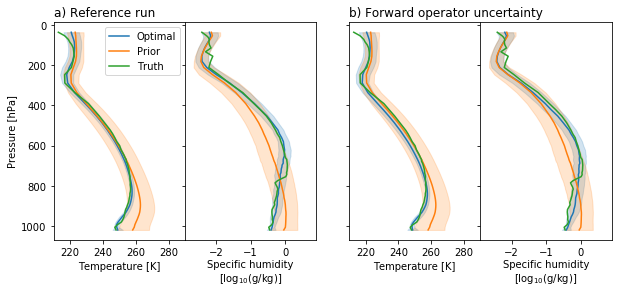

In [48]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_b,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Forward operator uncertainty',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)



... but the RMS errors are increased in comparison to the reference run.

In [49]:
print('Reference run:')
supporting_routines.print_mwr_rms(oe_ref)
print('Concidering forward model error:')
supporting_routines.print_mwr_rms(oe_b)


Reference run:
RMS X Temperature: 1.78812 [K]
RMS X Humidity: 0.148654 [log$_{10}$(g/kg)]
RMS Y 0.0436155 [K]
Concidering forward model error:
RMS X Temperature: 2.28415 [K]
RMS X Humidity: 0.152141 [log$_{10}$(g/kg)]
RMS Y 0.17877 [K]



We can also look at the ratio between prior and posterior uncertainty for $\mathbf{x}$ (ratio of the squared diagonals of **S**$_{a}$ and **S**$_{op}$)which shows the improvement in the state estimate by the retrieval. Also, we compare the $d$ estimates for the individual elements of  $\mathbf{x}$


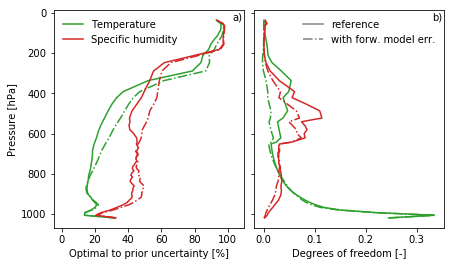

In [50]:
fig = supporting_routines.plot_uncertainty_dof(
    oe_ref, oe_b, 'with forw. model err.',
    pressure.sel(season='MAM') / 100)


Comparison of the reference run and the run considering **S**$_b$ reveals that the relative uncertainty improvement is overestimated by up to 11% for individual elements of $\mathbf{x}$

In [51]:
((oe_b.x_op_err/oe_b.x_a_err) - (oe_ref.x_op_err/oe_ref.x_a_err)).max() * 100

11.22433686296863

Even though **S**$_b$ has the highest values in the V-band channels relevant for the temperature retrieval, the loss in information content ($d$) is spread almost evenly on the humidity and temperature variables

In [52]:
print('Change in degrees of freedom for temperature variables %g' %
      (supporting_routines.splitTQ(oe_ref.dgf_x)[0].sum() -
       supporting_routines.splitTQ(oe_b.dgf_x)[0].sum()))
print('Change in degrees of freedom for humidity variables %g' %
      (supporting_routines.splitTQ(oe_ref.dgf_x)[1].sum() -
       supporting_routines.splitTQ(oe_b.dgf_x)[1].sum()))

Change in degrees of freedom for temperature variables 0.449552
Change in degrees of freedom for humidity variables 0.446728


With respect to the statistical tests, there are no differences to the reference run

In [53]:
print(oe_b.chiSquareTest()[0])
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_ref.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 11 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool
Linearity test passed:  True


In summary, **S**$_b$ can have a crucial impact on the uncertainty estimates of a retrieval and neglecting **S**$_b$ can lead to an overestimation of a retrieval's performance.

## Measurement uncertainty: Reduce and increase

Also, the measurement uncertainty **S**$_y$ used for **S**$_e$ needs to be carefully chosen.  **S**$_y$ is the most important regulator between measurement and prior: underestimating  **S**$_y$ puts too much weight on the measurements so that the retrieval underestimate uncertainties, overestimate $d$ and/or even not converge. When overestimating  **S**$_y$, the retrieval stays close to the prior. In contrast to  **S**$_a$, there is no easy test to assess whether  **S**$_y$ was chosen properly. In the following, we show the impact of multiplying and dividing **S**$_y$ with a factor of 4 which is equivalent to applying a factor of 2 to the uncertainties. 

We configure the retrieval similar to the reference run, but double the measurement uncertainties (i.e., multiply **S**$_y$ with 4):

In [54]:
x_a = x_mean.sel(season='MAM').to_pandas() # as reference
S_a = x_cov.sel(season='MAM').to_pandas() # as reference
S_e = S_y * 4

oe_double = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_e,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_double.doRetrieval()

4.45 s, iteration 1, degrees of freedom: 3.96 of 120. convergence criteria NOT fullfilled  112.969
6.43 s, iteration 2, degrees of freedom: 3.92 of 120. convergence criteria NOT fullfilled  2.569
8.56 s, iteration 3, degrees of freedom: 3.92 of 120. convergence criteria fullfilled  0.013
11.33 s, iteration 4, degrees of freedom: 3.92 of 120.  Done.  0.000


True

The same for halved measurement uncertainty

In [55]:
x_a = x_mean.sel(season='MAM').to_pandas() #as before
S_a = x_cov.sel(season='MAM').to_pandas() #as before
S_e = S_y / 4

oe_half = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_e,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs,
)
oe_half.doRetrieval()

4.54 s, iteration 1, degrees of freedom: 5.49 of 120. convergence criteria NOT fullfilled  5385.555
6.16 s, iteration 2, degrees of freedom: 5.44 of 120. convergence criteria NOT fullfilled  148.037
7.93 s, iteration 3, degrees of freedom: 5.43 of 120. convergence criteria fullfilled  0.747
9.69 s, iteration 4, degrees of freedom: 5.44 of 120.  Done.  0.002


True

By eye, no significant difference is visible in the retrieved profiles 

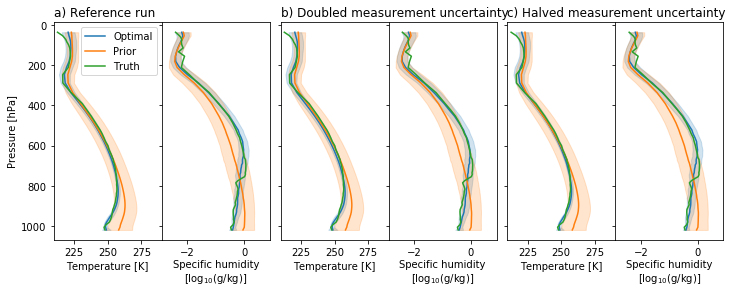

In [56]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_double,
    oe3 = oe_half,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Doubled measurement uncertainty',
    title3='c) Halved measurement uncertainty',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)


The increased (reduced) RMS difference between $\mathbf{x}_{op}$ and $\mathbf{x}_{a}$ for doubled (halved) measurement uncertainties shows that $\mathbf{x}_{op}$ is closer to (further from) $\mathbf{x}_{a}$ 

In [57]:
print('### Reference run ###')
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_ref.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_ref.x_a)
print('Temperature RMS difference to x_a: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('Humidity RMS difference to x_a: %g [log10(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))

print('\n### Doubled measurement uncertainty ###')
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_double.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_double.x_a)
print('Temperature RMS difference to x_a: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('Humidity RMS difference to x_a: %g [log10(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))

print('\n### Halved measurement uncertainty ###')
T_optimal, Q_optimal = supporting_routines.splitTQ(oe_half.x_op)
T_truth, Q_truth = supporting_routines.splitTQ(oe_half.x_a)
print('Temperature RMS difference to x_a: %g [K]'% np.sqrt(np.mean((T_optimal - T_truth)**2)))
print('Humidity RMS difference to x_a: %g [log10(g/kg)]'% np.sqrt(np.mean((10**Q_optimal - 10**Q_truth)**2)))



### Reference run ###
Temperature RMS difference to x_a: 4.53031 [K]
Humidity RMS difference to x_a: 0.343216 [log10(g/kg)]

### Doubled measurement uncertainty ###
Temperature RMS difference to x_a: 4.52769 [K]
Humidity RMS difference to x_a: 0.326967 [log10(g/kg)]

### Halved measurement uncertainty ###
Temperature RMS difference to x_a: 4.54412 [K]
Humidity RMS difference to x_a: 0.35248 [log10(g/kg)]


However, the reduction in uncertainty and the individual $d$ change with respect to the reference run

Change in degrees of freedom for halved measurement uncertainties -0.768446
Change in degrees of freedom for doubled measurement uncertainties 0.74471


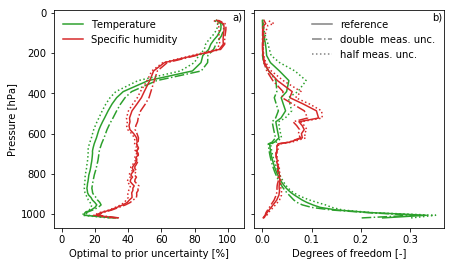

In [58]:

fig = supporting_routines.plot_uncertainty_dof(
    oe_ref, oe_double, 'double  meas. unc.',
    pressure.sel(season='MAM') / 100,
    oe3=oe_half, label3 = 'half meas. unc.'
)

print('Change in degrees of freedom for halved measurement uncertainties %g' %
      (oe_ref.dgf - oe_half.dgf))
print('Change in degrees of freedom for doubled measurement uncertainties %g' %
      (oe_ref.dgf - oe_double.dgf))



No changes with respect to the $\chi^2$ test for the version with doubled

In [59]:
print(oe_double.chiSquareTest()[0])
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_double.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 11 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool
Linearity test passed:  True


... and halved uncertainties

In [60]:
print(oe_half.chiSquareTest()[0])
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_half.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Warning. Singular Matrix with rank 12 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool
Linearity test passed:  True


In summary, **S**$_y$ is a powerful variables determining the retrieval uncertainty and the balance between prior and measurement information.

## Consider non-diagonal elements of the measurement uncertainty

Besides the magnitude, also the structure of **S**$_y$ is crucial which we illustrate with the effect of the non-diagonal elements. For an ideal instrument, the various measurements would be totally independent and the noise uncorrelated. Due to hardware limitations, however, this is typically not the case. In the following, we consider non-diagonal elements of Sy as proposed by (ULI ???). Note that the diagonal elements of **S**$_{y}$ are not modified. 


Text(0.5, 1.0, 'Measurement uncertainty $\\mathbf{S}_{y}$ including non-diagonal elements.')

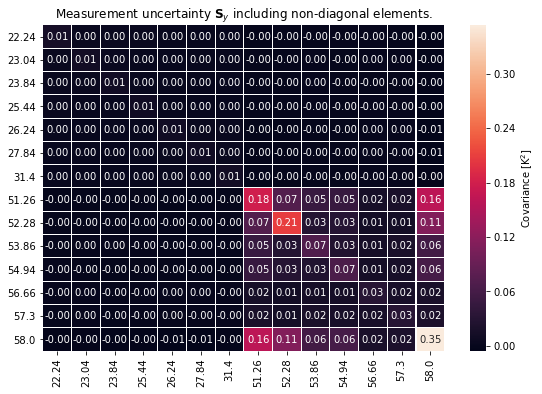

In [61]:
S_y_nondiag = np.array(
    [[
        1.4464e-02, 3.1175e-03, 3.2584e-03, 2.7590e-03, 2.1494e-03, 1.8121e-03,
        2.3444e-03, -2.8253e-03, -1.1941e-03, -7.1487e-04, -7.1019e-05,
        -1.3676e-04, -3.0526e-04, -3.8639e-03
    ],
     [
         3.1175e-03, 1.1803e-02, 2.5663e-03, 2.1457e-03, 1.5946e-03,
         1.6916e-03, 1.8975e-03, -7.3124e-04, -4.7555e-04, 1.8126e-04,
         -8.1855e-04, 4.6114e-04, 3.1963e-06, -2.5867e-03
     ],
     [
         3.2584e-03, 2.5663e-03, 1.0841e-02, 2.3239e-03, 1.1311e-03,
         1.1062e-03, 1.5767e-03, -6.4790e-04, -1.3201e-03, 1.7669e-04,
         -1.0165e-03, -4.5220e-04, -5.8443e-04, -1.9019e-03
     ],
     [
         2.7590e-03, 2.1457e-03, 2.3239e-03, 8.4360e-03, 1.3579e-03,
         1.5264e-03, 1.4780e-03, -8.7548e-04, -1.5626e-03, -1.7332e-04,
         -4.6437e-04, -1.8432e-04, -1.7265e-04, -3.8433e-03
     ],
     [
         2.1494e-03, 1.5946e-03, 1.1311e-03, 1.3579e-03, 1.0352e-02,
         3.3218e-03, 3.1755e-03, -2.2734e-03, -2.3389e-03, -1.2198e-03,
         -7.2950e-04, 2.0710e-04, 2.5822e-04, -5.9091e-03
     ],
     [
         1.8121e-03, 1.6916e-03, 1.1062e-03, 1.5264e-03, 3.3218e-03,
         1.0172e-02, 3.2801e-03, -2.0768e-03, -2.1563e-03, -4.6483e-04,
         -1.6465e-03, 9.4358e-05, -2.8649e-04, -5.4612e-03
     ],
     [
         2.3444e-03, 1.8975e-03, 1.5767e-03, 1.4780e-03, 3.1755e-03,
         3.2801e-03, 1.1026e-02, -3.1658e-04, -1.1692e-03, -7.5206e-04,
         -1.0920e-03, -3.7627e-05, -2.0978e-04, -1.7690e-03
     ],
     [
         -2.8253e-03, -7.3124e-04, -6.4790e-04, -8.7548e-04, -2.2734e-03,
         -2.0768e-03, -3.1658e-04, 1.7896e-01, 7.2248e-02, 4.8262e-02,
         4.6481e-02, 1.6283e-02, 1.8456e-02, 1.6027e-01
     ],
     [
         -1.1941e-03, -4.7555e-04, -1.3201e-03, -1.5626e-03, -2.3389e-03,
         -2.1563e-03, -1.1692e-03, 7.2248e-02, 2.0847e-01, 2.8595e-02,
         2.9832e-02, 1.1226e-02, 1.3614e-02, 1.1240e-01
     ],
     [
         -7.1487e-04, 1.8126e-04, 1.7669e-04, -1.7332e-04, -1.2198e-03,
         -4.6483e-04, -7.5206e-04, 4.8262e-02, 2.8595e-02, 6.9126e-02,
         2.5361e-02, 1.3994e-02, 1.8141e-02, 5.6810e-02
     ],
     [
         -7.1019e-05, -8.1855e-04, -1.0165e-03, -4.6437e-04, -7.2950e-04,
         -1.6465e-03, -1.0920e-03, 4.6481e-02, 2.9832e-02, 2.5361e-02,
         6.5223e-02, 1.3962e-02, 1.6982e-02, 6.0963e-02
     ],
     [
         -1.3676e-04, 4.6114e-04, -4.5220e-04, -1.8432e-04, 2.0710e-04,
         9.4358e-05, -3.7627e-05, 1.6283e-02, 1.1226e-02, 1.3994e-02,
         1.3962e-02, 3.1456e-02, 1.7948e-02, 1.8197e-02
     ],
     [
         -3.0526e-04, 3.1963e-06, -5.8443e-04, -1.7265e-04, 2.5822e-04,
         -2.8649e-04, -2.0978e-04, 1.8456e-02, 1.3614e-02, 1.8141e-02,
         1.6982e-02, 1.7948e-02, 3.0822e-02, 2.1850e-02
     ],
     [
         -3.8639e-03, -2.5867e-03, -1.9019e-03, -3.8433e-03, -5.9091e-03,
         -5.4612e-03, -1.7690e-03, 1.6027e-01, 1.1240e-01, 5.6810e-02,
         6.0963e-02, 1.8197e-02, 2.1850e-02, 3.5390e-01
     ]])

S_y_nondiag = pn.DataFrame(
    S_y_nondiag,
    index=y_vars,
    columns=y_vars,
)
f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(S_y_nondiag, annot=True, fmt='.2f', ax=ax, linewidths=.05, cbar_kws={'label':'Covariance [K$^2$]'})

ax.set_title(r'Measurement uncertainty $\mathbf{S}_{y}$ including non-diagonal elements.')



In [62]:
x_a = x_mean.sel(season='MAM').to_pandas()[x_vars] # as reference run
S_a = x_cov.sel(season='MAM').to_pandas().loc[x_vars, x_vars] # as reference run
S_e = S_y_nondiag

oe_nondiag = pyOE.optimalEstimation(
    x_vars,
    x_a,
    S_a,
    y_vars,
    y_obs,
    S_e,
    forwardRT,
    x_truth=x_truth,
    forwardKwArgs=forwardKwArgs
)
oe_nondiag.doRetrieval()

5.01 s, iteration 1, degrees of freedom: 4.90 of 120. convergence criteria NOT fullfilled  578.946
7.55 s, iteration 2, degrees of freedom: 4.86 of 120. convergence criteria NOT fullfilled  14.357
9.21 s, iteration 3, degrees of freedom: 4.86 of 120. convergence criteria fullfilled  0.072
10.85 s, iteration 4, degrees of freedom: 4.86 of 120.  Done.  0.000


True

The retrieved vertical profiles look similar to the reference run 

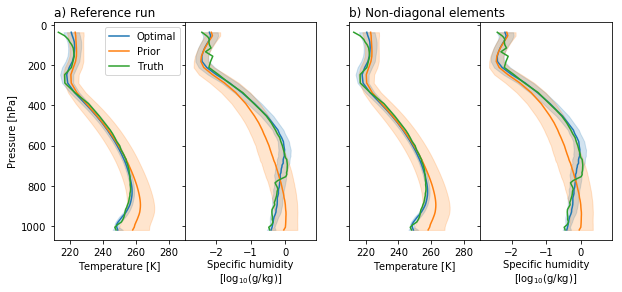

In [63]:
fig = supporting_routines.plotMwrResults(
    oe_ref,
    oe2 = oe_nondiag,
    h=pressure.sel(season=season) / 100,
    hlabel='Pressure [hPa]',
    title='a) Reference run',
    title2='b) Non-diagonal elements',
    xlimT = (210, 290),
    xlimH = (-2.9,0.9),
)



but interestingly, $d$ *increases* when considering non-diagonal elements

In [64]:
oe_nondiag.dgf - oe_ref.dgf

0.18964095110891854

... and also the uncertainty of $\mathbf{x}_{op}$ is reduced in comparison to the reference run ven though the change is small

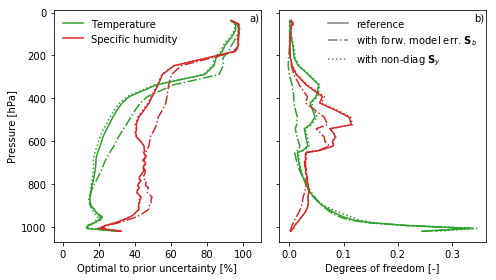

In [69]:
fig = supporting_routines.plot_uncertainty_dof(
    oe_ref, oe_b, 'with forw. model err. $\mathbf{S}_b$',
    pressure.sel(season='MAM') / 100,
    oe3=oe_nondiag, label3 = 'with non-diag $\mathbf{S}_y$'
)
fig.tight_layout()
fig.savefig('figure3.pdf')

There are no changes with respect to the $\chi^2$ tests as expected

In [66]:
print(oe_nondiag.chiSquareTest()[0])
linearity, trueLinearityChi2, trueLinearityChi2Crit = oe_nondiag.linearityTest(significance=0.05)
print('Linearity test passed: ', trueLinearityChi2 < trueLinearityChi2Crit)

Warning. Singular Matrix with rank 13 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 7 instead of 14. (This is typically save to ignore)       
Warning. Singular Matrix with rank 12 instead of 120. (This is typically save to ignore)       
chi2test
Y_Optimal_vs_Observation    True
Y_Observation_vs_Prior      True
Y_Optimal_vs_Prior          True
X_Optimal_vs_Prior          True
dtype: bool
Linearity test passed:  True


In summary, accounting for non-diagonal elements of **S**$_y$ is one of the few occasions where considering ‘additional’ error sources leads to an enhancement instead of a decrease of retrieval quality, because correlations between the different elements of y (i.e., the different channels in the microwave radiometer) can reduce the effective noise of the instrument. 

# References

Cimini, D., P. W. Rosenkranz, M. Y. Tretyakov, M. A. Koshelev, and F. Romano, 2018: Uncertainty of atmospheric microwave absorption model: impact on ground-based radiometer simulations and retrievals. *Atmospheric Chemistry and Physics*, 18, 15231–15259, https://doi.org/10.5194/acp-18-15231-2018.

Löhnert, U., S. Crewell, and C. Simmer, 2004: An Integrated Approach toward Retrieving Physically Consistent Profiles of Temperature, Humidity, and Cloud Liquid Water. *J. Appl. Meteor.*, 43, 1295–1307, [https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2](https://doi.org/10.1175/1520-0450(2004)043<1295:AIATRP>2.0.CO;2).

Rose, T., S. Crewell, U. Lohnert, and C. Simmer, 2005: A network suitable microwave radiometer for operational monitoring of the cloudy atmosphere. *Atmos. Res.*, 75, 183–200, https://doi.org/10.1016/j.atmosres.2004.12.005.  
  